In [ ]:
### Install Requirement
!pip install -r requirements.txt

In [106]:
%load_ext autoreload
%autoreload
%matplotlib inline
%config IPCompleter.greedy=True

import gc
import os
import logging
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
%load_ext autoreload
%autoreload
%matplotlib inline


import gc
import os
import logging
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [272]:
import util_model
import util_feature
import util_plot

print("ok")



ok


# Data Loading, basic profiling

In [3]:
folder = os.getcwd() + "/"



In [281]:
df = pd.read_csv(folder + '/data/address_matching_data.csv')
df.head(5)




,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality,is_match
0,1204#1207,0.666667,0.666667,0.400000,0.526316,?,?,?,?,?,...,?,?,?,?,1.0,1.0,m,m,s,1
1,1272#1279,0.666667,0.666667,0.411765,0.444444,?,?,?,?,?,...,?,?,?,?,1.0,1.0,m,m,s,1
2,6258#6259,1.000000,1.000000,1.000000,1.000000,1,1,1,1,1,...,1.0,1.0,?,?,1.0,1.0,s,m,s,1
3,16076#16077,0.565476,0.333333,0.260870,0.189189,?,?,?,?,?,...,1.0,1.0,?,?,0.0,0.0,s,m,n,-1
4,2666#2671,0.666667,0.666667,0.500000,0.518519,1,1,1,1,1,...,1.0,1.0,?,?,1.0,1.0,s,m,s,1


In [282]:
df.describe()


,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,is_match
count,28235.000000,28235.000000,28235.000000,28235.000000,28235.00000
mean,0.628171,0.563277,0.537006,0.509530,0.43524
std,0.304767,0.369004,0.324820,0.372265,0.90033
min,0.000000,0.000000,0.000000,0.000000,-1.00000
25%,0.363387,0.222222,0.243243,0.142857,-1.00000
50%,0.666667,0.666667,0.476190,0.483871,1.00000
75%,1.000000,1.000000,0.875000,1.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.00000


In [283]:
df.columns, df.dtypes

(Index(['id', 'name_levenshtein_simple', 'name_trigram_simple',
        'name_levenshtein_term', 'name_trigram_term', 'city_levenshtein_simple',
        'city_trigram_simple', 'city_levenshtein_term', 'city_trigram_term',
        'zip_levenshtein_simple', 'zip_trigram_simple', 'zip_levenshtein_term',
        'zip_trigram_term', 'street_levenshtein_simple',
        'street_trigram_simple', 'street_levenshtein_term',
        'street_trigram_term', 'website_levenshtein_simple',
        'website_trigram_simple', 'website_levenshtein_term',
        'website_trigram_term', 'phone_levenshtein', 'phone_trigram',
        'fax_levenshtein', 'fax_trigram', 'street_number_levenshtein',
        'street_number_trigram', 'phone_equality', 'fax_equality',
        'street_number_equality', 'is_match'],
       dtype='object'), id                             object
 name_levenshtein_simple       float64
 name_trigram_simple           float64
 name_levenshtein_term         float64
 name_trigram_term      

In [7]:
### Pandas Profiling for features
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
import pandas_profiling as pp
profile =  df.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="output.html")


colexclude = profile.get_rejected_variables(threshold=0.98)
colexclude 



In [8]:
colexclude = profile.get_rejected_variables(threshold=0.98)
colexclude 



['name_trigram_simple']

# Column selection by type

In [284]:
colid = "id"
colnum = ['name_levenshtein_simple', 'name_trigram_simple',
        'name_levenshtein_term', 'name_trigram_term', 'city_levenshtein_simple',
        'city_trigram_simple', 'city_levenshtein_term', 'city_trigram_term',
        'zip_levenshtein_simple', 'zip_trigram_simple', 'zip_levenshtein_term',
        'zip_trigram_term', 'street_levenshtein_simple',
        'street_trigram_simple', 'street_levenshtein_term',
        'street_trigram_term', 'website_levenshtein_simple',
        'website_trigram_simple', 'website_levenshtein_term',
        'website_trigram_term', 'phone_levenshtein', 'phone_trigram',
        'fax_levenshtein', 'fax_trigram', 'street_number_levenshtein',
        'street_number_trigram']

colcat = [ 'phone_equality', 'fax_equality',
          'street_number_equality']
coltext = []

coldate = []

coly = "is_match"


colall = colnum + colcat + coltext

"""

dfnum, dfcat, dfnum_bin, 
dfnum_binhot,  dfcat_hot

colnum, colcat, coltext, 
colnum_bin, colnum_binhot,  

"""

print(colall )


['name_levenshtein_simple', 'name_trigram_simple', 'name_levenshtein_term', 'name_trigram_term', 'city_levenshtein_simple', 'city_trigram_simple', 'city_levenshtein_term', 'city_trigram_term', 'zip_levenshtein_simple', 'zip_trigram_simple', 'zip_levenshtein_term', 'zip_trigram_term', 'street_levenshtein_simple', 'street_trigram_simple', 'street_levenshtein_term', 'street_trigram_term', 'website_levenshtein_simple', 'website_trigram_simple', 'website_levenshtein_term', 'website_trigram_term', 'phone_levenshtein', 'phone_trigram', 'fax_levenshtein', 'fax_trigram', 'street_number_levenshtein', 'street_number_trigram', 'phone_equality', 'fax_equality', 'street_number_equality']


In [285]:
df = df.set_index( colid )

# Data type normalization, Encoding process (numerics, category)

In [286]:
#Normalize to NA, NA Handling
df = df.replace("?", np.nan)



In [287]:
### colnum procesing 
for x in colnum :
    df[x] = df[x].astype("float32")

print( df.dtypes )

name_levenshtein_simple       float32
name_trigram_simple           float32
name_levenshtein_term         float32
name_trigram_term             float32
city_levenshtein_simple       float32
city_trigram_simple           float32
city_levenshtein_term         float32
city_trigram_term             float32
zip_levenshtein_simple        float32
zip_trigram_simple            float32
zip_levenshtein_term          float32
zip_trigram_term              float32
street_levenshtein_simple     float32
street_trigram_simple         float32
street_levenshtein_term       float32
street_trigram_term           float32
website_levenshtein_simple    float32
website_trigram_simple        float32
website_levenshtein_term      float32
website_trigram_term          float32
phone_levenshtein             float32
phone_trigram                 float32
fax_levenshtein               float32
fax_trigram                   float32
street_number_levenshtein     float32
street_number_trigram         float32
phone_equali

In [121]:
##### Colcat processing 
colcat_map = pd_colcat_mapping(df, colcat) 
                
#for col in colcat :
#    df[col] =  df[col].apply(lambda x : colcat_map["cat_map"][col].get(x)  )

print( df[colcat].dtypes , colcat_map)



phone_equality            int64
fax_equality              int64
street_number_equality    int64
dtype: object {'cat_map': {'phone_equality': {0: 0, 1: 1, 2: 2}, 'fax_equality': {0: 0, 1: 1, 2: 2}, 'street_number_equality': {0: 0, 1: 1, 2: 2}}, 'cat_map_inverse': {'phone_equality': {0: 0, 1: 1, 2: 2}, 'fax_equality': {0: 0, 1: 1, 2: 2}, 'street_number_equality': {0: 0, 1: 1, 2: 2}}}


# Data Distribution after encoding/ data type normalization

In [31]:
#### ColTarget Distribution
coly_stat = pd_stat_distribution(df[  [  "id", coly ]] ,  subsample_ratio= 1.0)
coly_stat




Univariate distribution
id must be str, not float


,col,n,n_na,n_notna,n_na_pct,nunique,nunique_pct,xmin,xmin_freq,xmin_pct,xmax,xmax_freq,xmax_pct,xmed,xmed_freq,xmed_pct
0,is_match,28235.0,0.0,28235,0.0,2,0.000071,-1,7973,0.28238,1,20262,0.71762,1.0,20262,0.71762


In [32]:
#### Col numerics distribution
colnum_stat = pd_stat_distribution(df[colnum],  subsample_ratio= 0.6)
colnum_stat


Univariate distribution


,col,n,n_na,n_notna,n_na_pct,nunique,nunique_pct,xmin,xmin_freq,xmin_pct,xmax,xmax_freq,xmax_pct,xmed,xmed_freq,xmed_pct
0,name_levenshtein_simple,16941.0,0.0,16941,0.000000,2577,0.152116,0.000000,126,0.007438,1.0,4227,0.249513,0.666667,3404,0.200933
1,name_trigram_simple,16941.0,0.0,16941,0.000000,1389,0.081990,0.000000,2029,0.119769,1.0,4227,0.249513,0.666667,2914,0.172009
2,name_levenshtein_term,16941.0,0.0,16941,0.000000,652,0.038487,0.000000,151,0.008913,1.0,3891,0.229679,0.473684,3038,0.179328
3,name_trigram_term,16941.0,0.0,16941,0.000000,791,0.046691,0.000000,2027,0.119651,1.0,4243,0.250457,0.478261,2737,0.161561
4,city_levenshtein_simple,16941.0,11021.0,5920,0.650552,174,0.010271,0.000000,81,0.004781,1.0,4566,0.269524,1.000000,4579,0.270291
5,city_trigram_simple,16941.0,11021.0,5920,0.650552,91,0.005372,0.000000,390,0.023021,1.0,4566,0.269524,1.000000,4566,0.269524
6,city_levenshtein_term,16941.0,11021.0,5920,0.650552,99,0.005844,0.000000,81,0.004781,1.0,4674,0.275899,1.000000,4675,0.275958
7,city_trigram_term,16941.0,11021.0,5920,0.650552,100,0.005903,0.000000,390,0.023021,1.0,4678,0.276135,1.000000,4678,0.276135
8,zip_levenshtein_simple,16941.0,12328.0,4613,0.727702,17,0.001003,0.000000,191,0.011274,1.0,3549,0.209492,1.000000,3549,0.209492
9,zip_trigram_simple,16941.0,12328.0,4613,0.727702,20,0.001181,0.000000,344,0.020306,1.0,3552,0.209669,1.000000,3552,0.209669


In [33]:
#### Col stats distribution
colcat_stat = pd_stat_distribution(df[colcat], subsample_ratio= 0.3)
colcat_stat




Univariate distribution


,col,n,n_na,n_notna,n_na_pct,nunique,nunique_pct,xmin,xmin_freq,xmin_pct,xmax,xmax_freq,xmax_pct,xmed,xmed_freq,xmed_pct
0,phone_equality,8470.0,0.0,8470,0.0,3,0.000354,0,4946,0.583943,2,2322,0.274144,0.0,4946,0.583943
1,fax_equality,8470.0,0.0,8470,0.0,3,0.000354,0,8258,0.974970,2,109,0.012869,0.0,8258,0.974970
2,street_number_equality,8470.0,0.0,8470,0.0,3,0.000354,0,236,0.027863,2,4214,0.497521,1.0,4020,0.474616


# Feature processing (strategy 1)

In [16]:
### BAcKUP data before Pre-processing
dfref = copy.deepcopy( df )
print(dfref.shape)

(28235, 31)


In [27]:
"""
Many strategies are possible :
   1) Feature selection before the model
   2) Feature selection using model accuracy.
   
Unless of those cases :
   variable with correl > 99% (ie > imablance class %).
   variable with variance of 0 (as 0).
   Its better to keep all variables at 1st.
   Only Linear model (ie Regression, Logitsic) : 




"""




## Colnum

In [124]:
## Map numerics to Category bin
dfnum, colnum_binmap = pd_colnum_tocat(df, colname=colnum, colexclude=None, colbinmap=None,
                                  bins=5, suffix="_bin",    method="uniform",
                                  return_val="dataframe,param")


print(colnum_binmap)

name_levenshtein_simple
                            name_levenshtein_simple                           
                                                min   size      mean       max
name_levenshtein_simple_bin                                                   
0                                               0.0   3244  0.133234  0.199916
1                                               0.2   4352  0.284679  0.399802
2                                               0.4   4713  0.495519  0.599206
3                                               0.6   4992  0.679888  0.797778
4                                               0.8  10934  0.945298  1.000000
name_trigram_simple
                        name_trigram_simple                           
                                        min   size      mean       max
name_trigram_simple_bin                                               
0                                       0.0   6913  0.034203  0.199356
1                                       

 4                             1.000000  
street_trigram_simple
                          street_trigram_simple                           
                                            min   size      mean       max
street_trigram_simple_bin                                                 
-1                                          NaN  19997       NaN       NaN
 0                                          0.0   1669  0.038069  0.198485
 1                                          0.2   1020  0.281841  0.399669
 2                                          0.4    575  0.499309  0.596875
 3                                          0.6   1026  0.706532  0.793651
 4                                          0.8   3948  0.958941  1.000000
street_levenshtein_term
                            street_levenshtein_term                           
                                                min   size      mean       max
street_levenshtein_term_bin                                                   


 4                             1.000000  
street_number_trigram
                          street_number_trigram                           
                                            min   size      mean       max
street_number_trigram_bin                                                 
-1                                          NaN   9852       NaN       NaN
 0                                          0.0    551  0.073064  0.181818
 1                                          0.2   3084  0.270634  0.375000
 2                                          0.4    684  0.447116  0.571429
 4                                          1.0  14064  1.000000  1.000000
OrderedDict([('name_levenshtein_simple', [-0.0001, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]), ('name_trigram_simple', [-0.0001, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]), ('name_levenshtein_term', [-0.0001, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]), ('name_trigram_term', [-0.0001, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]), ('city_levensht

In [125]:
colnum_bin =  [  x + "_bin" for x in  list( colnum_map.keys() )   ]
print( colnum_bin )




['name_levenshtein_simple_bin', 'name_trigram_simple_bin', 'name_levenshtein_term_bin', 'name_trigram_term_bin', 'city_levenshtein_simple_bin', 'city_trigram_simple_bin', 'city_levenshtein_term_bin', 'city_trigram_term_bin', 'zip_levenshtein_simple_bin', 'zip_trigram_simple_bin', 'zip_levenshtein_term_bin', 'zip_trigram_term_bin', 'street_levenshtein_simple_bin', 'street_trigram_simple_bin', 'street_levenshtein_term_bin', 'street_trigram_term_bin', 'website_levenshtein_simple_bin', 'website_trigram_simple_bin', 'website_levenshtein_term_bin', 'website_trigram_term_bin', 'phone_levenshtein_bin', 'phone_trigram_bin', 'fax_levenshtein_bin', 'fax_trigram_bin', 'street_number_levenshtein_bin', 'street_number_trigram_bin']


In [169]:
dfnum.columns



Index(['name_levenshtein_simple_bin', 'name_trigram_simple_bin',
       'name_levenshtein_term_bin', 'name_trigram_term_bin',
       'city_levenshtein_simple_bin', 'city_trigram_simple_bin',
       'city_levenshtein_term_bin', 'city_trigram_term_bin',
       'zip_levenshtein_simple_bin', 'zip_trigram_simple_bin',
       'zip_levenshtein_term_bin', 'zip_trigram_term_bin',
       'street_levenshtein_simple_bin', 'street_trigram_simple_bin',
       'street_levenshtein_term_bin', 'street_trigram_term_bin',
       'website_levenshtein_simple_bin', 'website_trigram_simple_bin',
       'website_levenshtein_term_bin', 'website_trigram_term_bin',
       'phone_levenshtein_bin', 'phone_trigram_bin', 'fax_levenshtein_bin',
       'fax_trigram_bin', 'street_number_levenshtein_bin',
       'street_number_trigram_bin'],
      dtype='object')

In [128]:
### numerics bin to One Hot
dfnum_hot, colnum_onehot = pd_col_to_onehot(dfnum[colnum_bin], colname=colnum_bin,
                             colonehot=None, return_val="dataframe,param")
dfnum_hot[ colnum_onehot   ] .head(10)



name_levenshtein_simple_bin 5 (28235, 26)
name_trigram_simple_bin 5 (28235, 30)
name_levenshtein_term_bin 5 (28235, 34)
name_trigram_term_bin 5 (28235, 38)
city_levenshtein_simple_bin 6 (28235, 42)
city_trigram_simple_bin 6 (28235, 47)
city_levenshtein_term_bin 6 (28235, 52)
city_trigram_term_bin 6 (28235, 57)
zip_levenshtein_simple_bin 6 (28235, 62)
zip_trigram_simple_bin 6 (28235, 67)
zip_levenshtein_term_bin 6 (28235, 72)
zip_trigram_term_bin 6 (28235, 77)
street_levenshtein_simple_bin 6 (28235, 82)
street_trigram_simple_bin 6 (28235, 87)
street_levenshtein_term_bin 6 (28235, 92)
street_trigram_term_bin 6 (28235, 97)
website_levenshtein_simple_bin 6 (28235, 102)
website_trigram_simple_bin 6 (28235, 107)
website_levenshtein_term_bin 6 (28235, 112)
website_trigram_term_bin 6 (28235, 117)
phone_levenshtein_bin 6 (28235, 122)
phone_trigram_bin 6 (28235, 127)
fax_levenshtein_bin 6 (28235, 132)
fax_trigram_bin 6 (28235, 137)
street_number_levenshtein_bin 6 (28235, 142)
street_number_trigr

,name_levenshtein_simple_bin_0,name_levenshtein_simple_bin_1,name_levenshtein_simple_bin_2,name_levenshtein_simple_bin_3,name_levenshtein_simple_bin_4,name_trigram_simple_bin_0,name_trigram_simple_bin_1,name_trigram_simple_bin_2,name_trigram_simple_bin_3,name_trigram_simple_bin_4,...,street_number_levenshtein_bin_0,street_number_levenshtein_bin_1,street_number_levenshtein_bin_2,street_number_levenshtein_bin_3,street_number_levenshtein_bin_4,street_number_trigram_bin_-1,street_number_trigram_bin_0,street_number_trigram_bin_1,street_number_trigram_bin_2,street_number_trigram_bin_4
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
3,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
5,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
6,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
7,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
8,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [202]:
0


0

In [277]:
## To pipeline
#  Save each feature processing into "Reproductible pipeline".
#  For Scalability, for repreoduction process
#  Functionnal appraoch --> Can be converted to Spark
#  For scalbility, and paralell

from util_feature import pd_col_to_num, pd_colnum_tocat, pd_col_to_onehot

pipe_preprocess_colnum =[ 
           (util_feature.pd_col_to_num,   {"default": np.nan,} , "Conver string to NA")
           
          ,(util_feature.pd_colnum_tocat, { "colname":None, "colbinmap": colnum_binmap,  'bins': 5, 
                               "method": "uniform", "suffix":"_bin", "return_val": "dataframe"}, 
                               "Convert Numerics to Category " )
           
          ,(util_feature.pd_col_to_onehot, { "colname": None,  "colonehot": colnum_onehot,  
                                "return_val": "dataframe"  } , 
                                "Convert category to onehot" )
]




In [278]:
###Check pipeline
util_feature.pd_pipeline_apply( df[colnum].iloc[:10000,:], pipe_preprocess_colnum)  





############## Pipeline  0 Start (10000, 26) pd_col_to_num
############## Pipeline   0 Finished (10000, 26)
############## Pipeline  1 Start (10000, 26) pd_colnum_tocat
name_levenshtein_simple
                            name_levenshtein_simple                          
                                                min  size      mean       max
name_levenshtein_simple_bin                                                  
0                                               0.0  1173  0.133397  0.199916
1                                               0.2  1542  0.284577  0.399802
2                                               0.4  1624  0.497450  0.598214
3                                               0.6  1800  0.679548  0.797778
4                                               0.8  3861  0.945058  1.000000
name_trigram_simple
                        name_trigram_simple                          
                                        min  size      mean       max
name_trigram_simple_bin

 4                             1.000000  
street_trigram_simple
                          street_trigram_simple                          
                                            min  size      mean       max
street_trigram_simple_bin                                                
-1                                          NaN  7097       NaN       NaN
 0                                          0.0   581  0.036992  0.193182
 1                                          0.2   351  0.281695  0.398333
 2                                          0.4   199  0.507900  0.595238
 3                                          0.6   336  0.702810  0.793651
 4                                          0.8  1436  0.960018  1.000000
street_levenshtein_term
                            street_levenshtein_term                          
                                                min  size      mean       max
street_levenshtein_term_bin                                                  
-1          

 4                             1.000000  
street_number_trigram
                          street_number_trigram                          
                                            min  size      mean       max
street_number_trigram_bin                                                
-1                                          NaN  3487       NaN       NaN
 0                                          0.0   189  0.072162  0.181818
 1                                          0.2  1053  0.271602  0.375000
 2                                          0.4   239  0.445954  0.571429
 4                                          1.0  5032  1.000000  1.000000
############## Pipeline   1 Finished (10000, 26)
############## Pipeline  2 Start (10000, 26) pd_col_to_onehot
name_levenshtein_simple_bin 5 (10000, 26)
name_trigram_simple_bin 5 (10000, 30)
name_levenshtein_term_bin 5 (10000, 34)
name_trigram_term_bin 5 (10000, 38)
city_levenshtein_simple_bin 6 (10000, 42)
city_trigram_simple_bin 6 (10000, 4

,name_levenshtein_simple_bin_0,name_levenshtein_simple_bin_1,name_levenshtein_simple_bin_2,name_levenshtein_simple_bin_3,name_levenshtein_simple_bin_4,name_trigram_simple_bin_0,name_trigram_simple_bin_1,name_trigram_simple_bin_2,name_trigram_simple_bin_3,name_trigram_simple_bin_4,...,street_number_levenshtein_bin_0,street_number_levenshtein_bin_1,street_number_levenshtein_bin_2,street_number_levenshtein_bin_3,street_number_levenshtein_bin_4,street_number_trigram_bin_-1,street_number_trigram_bin_0,street_number_trigram_bin_1,street_number_trigram_bin_2,street_number_trigram_bin_4
id,,,,,,,,,,,,,,,,,,,,,
1204#1207,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
1272#1279,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
6258#6259,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
16076#16077,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2666#2671,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4402#4403,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4025#4028,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4126#4138,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4559#4560,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Colcat

In [288]:
dfcat_hot, colcat_onehot = pd_col_to_onehot(df[colcat], colname=colcat,  
                                         colonehot=None, return_val="dataframe,param")
dfcat_hot[colcat_onehot ].head(5)




phone_equality 3 (28235, 3)
fax_equality 3 (28235, 5)
street_number_equality 3 (28235, 7)


,phone_equality_m,phone_equality_n,phone_equality_s,fax_equality_m,fax_equality_n,fax_equality_s,street_number_equality_m,street_number_equality_n,street_number_equality_s
id,,,,,,,,,
1204#1207,1,0,0,1,0,0,0,0,1
1272#1279,1,0,0,1,0,0,0,0,1
6258#6259,0,0,1,1,0,0,0,0,1
16076#16077,0,0,1,1,0,0,0,1,0
2666#2671,0,0,1,1,0,0,0,0,1


In [135]:
print("Final features")

dfnum_hot.head(3) 
dfcat_hot.head(3) 



Final features


,phone_equality_0,phone_equality_1,phone_equality_2,fax_equality_0,fax_equality_1,fax_equality_2,street_number_equality_0,street_number_equality_1,street_number_equality_2
0,1,0,0,1,0,0,0,0,1
1,1,0,0,1,0,0,0,0,1
2,0,0,1,1,0,0,0,0,1


In [289]:
## To pipeline
#  Save each feature processing into "Reproductible pipeline".
#  For Scalability, for repreoduction process
#  Can be easily re-factored for PySpark )
pipe_preprocess_colcat =[ 
           (util_feature.pd_col_fillna, {"value": "-1", "method" : "",   "return_val": "dataframe" },
           )        

          ,(util_feature.pd_col_to_onehot, { "colname": None,  "colonehot": colcat_onehot,  
                                "return_val": "dataframe"  } , "convert to one hot")
]


###Check pipeline
util_feature.pd_pipeline_apply( df[colcat].iloc[:10,:], pipe_preprocess_colcat)  




############## Pipeline  0 Start (10, 3) pd_col_fillna
phone_equality 0 replaceBY -1
fax_equality 0 replaceBY -1
street_number_equality 0 replaceBY -1
############## Pipeline   0 Finished (10, 3)
############## Pipeline  1 Start (10, 3) pd_col_to_onehot
phone_equality 2 (10, 3)
fax_equality 1 (10, 3)
street_number_equality 2 (10, 3)
phone_equality_m added
phone_equality_n added
phone_equality_s added
fax_equality_m added
fax_equality_n added
fax_equality_s added
street_number_equality_m added
street_number_equality_n added
street_number_equality_s added
############## Pipeline   1 Finished (10, 9)


,phone_equality_m,phone_equality_n,phone_equality_s,fax_equality_m,fax_equality_n,fax_equality_s,street_number_equality_m,street_number_equality_n,street_number_equality_s
id,,,,,,,,,
1204#1207,0,0,0,0,0,0,0,0,0
1272#1279,0,0,0,0,0,0,0,0,0
6258#6259,0,0,0,0,0,0,0,0,0
16076#16077,0,0,0,0,0,0,0,0,0
2666#2671,0,0,0,0,0,0,0,0,0
4402#4403,0,0,0,0,0,0,0,0,0
4025#4028,0,0,0,0,0,0,0,0,0
4126#4138,0,0,0,0,0,0,0,0,0
4559#4560,0,0,0,0,0,0,0,0,0


NameError: name 'colnum_binmap' is not defined

## Coltext  

## Coldate

# Pre-Feature Selection

# Train data preparation

In [220]:
#### Train data preparation
dfX = pd.concat(( dfnum_hot, dfcat_hot ), axis=1)
colX = list( dfX.columns )

dfy = df[coly]
#X  = dfX.values
#yy = df[coly].values

Xtrain, Xtest, ytrain, ytest = train_test_split( dfX,  dfy,   
                                                 random_state=42,
                                                 test_size=0.5, shuffle=True)


print( Xtrain.shape, Xtest.shape, colX) 

(14117, 160) (14118, 160) ['name_levenshtein_simple_bin_0', 'name_levenshtein_simple_bin_1', 'name_levenshtein_simple_bin_2', 'name_levenshtein_simple_bin_3', 'name_levenshtein_simple_bin_4', 'name_trigram_simple_bin_0', 'name_trigram_simple_bin_1', 'name_trigram_simple_bin_2', 'name_trigram_simple_bin_3', 'name_trigram_simple_bin_4', 'name_levenshtein_term_bin_0', 'name_levenshtein_term_bin_1', 'name_levenshtein_term_bin_2', 'name_levenshtein_term_bin_3', 'name_levenshtein_term_bin_4', 'name_trigram_term_bin_0', 'name_trigram_term_bin_1', 'name_trigram_term_bin_2', 'name_trigram_term_bin_3', 'name_trigram_term_bin_4', 'city_levenshtein_simple_bin_-1', 'city_levenshtein_simple_bin_0', 'city_levenshtein_simple_bin_1', 'city_levenshtein_simple_bin_2', 'city_levenshtein_simple_bin_3', 'city_levenshtein_simple_bin_4', 'city_trigram_simple_bin_-1', 'city_trigram_simple_bin_0', 'city_trigram_simple_bin_1', 'city_trigram_simple_bin_2', 'city_trigram_simple_bin_3', 'city_trigram_simple_bin_4',

In [203]:
0

0

# Model evaluation

## Baseline : Logistic L2 penalty 

In [143]:

clf_log = sk.linear_model.LogisticRegression(penalty = 'l2' , class_weight = 'balanced')


############# Train dataset  ####################################
Test confusion matrix
[[3778  263]
 [ 711 9365]]
[[0.9349171  0.0650829 ]
 [0.07056372 0.92943628]]
auc 0.9823526793990026
gini 0.9647053587980052
acc 0.9310051710703408
f1macro 0.9181915919500756
Nsample 14117
              precision    recall  f1-score   support

           0       0.84      0.93      0.89      4041
           1       0.97      0.93      0.95     10076

   micro avg       0.93      0.93      0.93     14117
   macro avg       0.91      0.93      0.92     14117
weighted avg       0.94      0.93      0.93     14117



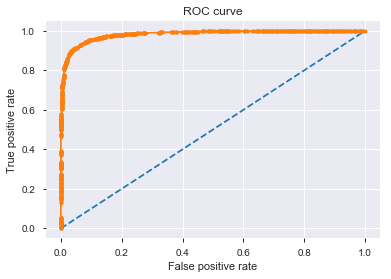

############# Test dataset  #########################################
Test confusion matrix
[[3662  270]
 [ 745 9441]]
[[0.93133266 0.06866734]
 [0.0731396  0.9268604 ]]
auc 0.9816998312566328
gini 0.9633996625132657
acc 0.9281059640175662
f1macro 0.9136350261166026
Nsample 14118
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3932
           1       0.97      0.93      0.95     10186

   micro avg       0.93      0.93      0.93     14118
   macro avg       0.90      0.93      0.91     14118
weighted avg       0.93      0.93      0.93     14118



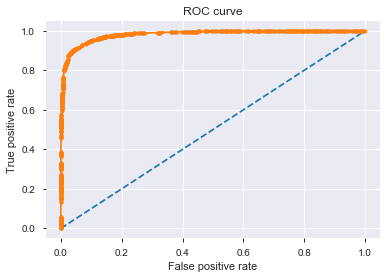

In [218]:
clf_log, clf_log_stats = sk_model_eval_classification(clf_log, 1,
                                           Xtrain, ytrain, Xtest, ytest)


In [ ]:
clf_log, dd = sk_model_eval_classification(clf_log, 1,
                                           Xtrain, ytrain, Xtest, ytest)



############# CV-0######################################
############# Train dataset  ####################################
Test confusion matrix
[[3618  278]
 [ 690 9531]]
[[0.92864476 0.07135524]
 [0.06750807 0.93249193]]
auc 0.9822612637507793
gini 0.9645225275015585
acc 0.9314301905504002
f1macro 0.9168406337349169
Nsample 14117
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3896
           1       0.97      0.93      0.95     10221

   micro avg       0.93      0.93      0.93     14117
   macro avg       0.91      0.93      0.92     14117
weighted avg       0.94      0.93      0.93     14117



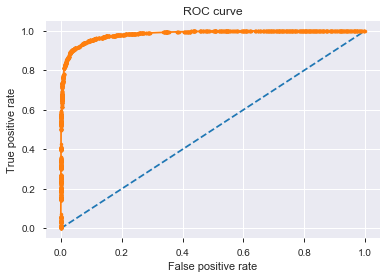

############# Test dataset  #########################################
Test confusion matrix
[[3796  281]
 [ 688 9353]]
[[0.93107677 0.06892323]
 [0.06851907 0.93148093]]
auc 0.9818862360178064
gini 0.9637724720356129
acc 0.9313642158946026
f1macro 0.9187809853110356
Nsample 14118
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4077
           1       0.97      0.93      0.95     10041

   micro avg       0.93      0.93      0.93     14118
   macro avg       0.91      0.93      0.92     14118
weighted avg       0.93      0.93      0.93     14118



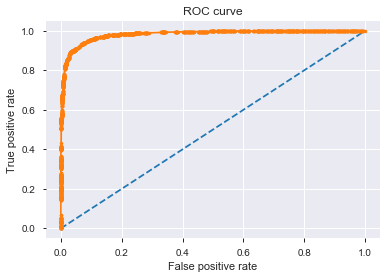

############# CV-1######################################
############# Train dataset  ####################################
Test confusion matrix
[[3712  247]
 [ 674 9484]]
[[0.93761051 0.06238949]
 [0.06635164 0.93364836]]
auc 0.9833504212627154
gini 0.9667008425254309
acc 0.9347595098108663
f1macro 0.921663753906078
Nsample 14117
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3959
           1       0.97      0.93      0.95     10158

   micro avg       0.93      0.93      0.93     14117
   macro avg       0.91      0.94      0.92     14117
weighted avg       0.94      0.93      0.94     14117



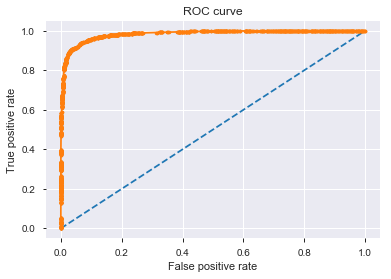

############# Test dataset  #########################################
Test confusion matrix
[[3734  280]
 [ 729 9375]]
[[0.93024415 0.06975585]
 [0.07214964 0.92785036]]
auc 0.9805649915517383
gini 0.9611299831034765
acc 0.9285309533928319
f1macro 0.9149533523406739
Nsample 14118
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4014
           1       0.97      0.93      0.95     10104

   micro avg       0.93      0.93      0.93     14118
   macro avg       0.90      0.93      0.91     14118
weighted avg       0.93      0.93      0.93     14118



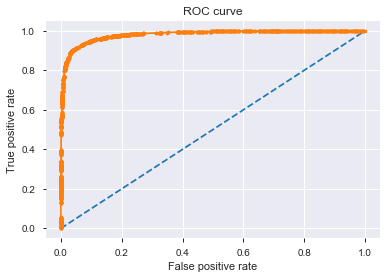

############# CV-2######################################
############# Train dataset  ####################################
Test confusion matrix
[[3795  252]
 [ 720 9350]]
[[0.93773165 0.06226835]
 [0.0714995  0.9285005 ]]
auc 0.9831533110578311
gini 0.9663066221156622
acc 0.9311468442303605
f1macro 0.9185323966163512
Nsample 14117
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4047
           1       0.97      0.93      0.95     10070

   micro avg       0.93      0.93      0.93     14117
   macro avg       0.91      0.93      0.92     14117
weighted avg       0.94      0.93      0.93     14117



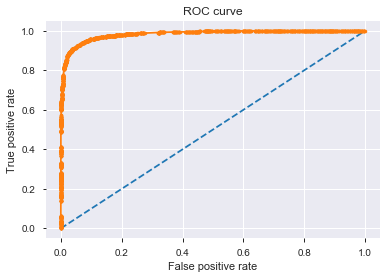

############# Test dataset  #########################################
Test confusion matrix
[[3648  278]
 [ 695 9497]]
[[0.92919002 0.07080998]
 [0.06819074 0.93180926]]
auc 0.9810854342422733
gini 0.9621708684845467
acc 0.9310808896444256
f1macro 0.9168005973915492
Nsample 14118
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3926
           1       0.97      0.93      0.95     10192

   micro avg       0.93      0.93      0.93     14118
   macro avg       0.91      0.93      0.92     14118
weighted avg       0.93      0.93      0.93     14118



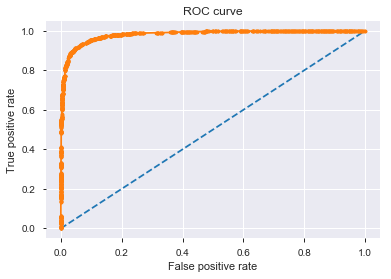

{0: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
           solver='warn', tol=0.0001, verbose=0, warm_start=False),
 1: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
           solver='warn', tol=0.0001, verbose=0, warm_start=False),
 2: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
           solver='warn', tol=0.0001, verbose=0, warm_start=False)}

In [221]:
sk_model_eval_classification_cv(clf_log,  dfX, dfy, test_size=0.5, ncv=3 )



In [213]:
clf_log_feat = sk_feature_impt_logis(clf_log, colX)
clf_log_feat.head(20) 



,feature,coef,coef_abs,rank
141,street_number_levenshtein_bin_0,-2.358337,2.358337,0
15,name_trigram_term_bin_0,-2.137965,2.137965,1
5,name_trigram_simple_bin_0,-2.093382,2.093382,2
87,street_trigram_term_bin_0,-2.021471,2.021471,3
126,phone_trigram_bin_3,1.977571,1.977571,4
9,name_trigram_simple_bin_4,1.926667,1.926667,5
18,name_trigram_term_bin_3,1.574609,1.574609,6
28,city_trigram_simple_bin_1,1.560024,1.560024,7
145,street_number_levenshtein_bin_4,1.502074,1.502074,8
127,phone_trigram_bin_4,1.466875,1.466875,9


In [149]:
clf_log_stats 

{'ytest_pred': array([ 1, -1, -1, ...,  1,  1,  1], dtype=int64)}


## Light GBM

In [222]:

clf_lgb = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l2', 
                         max_depth= 15, n_estimators = 50, objective= 'binary',
                         num_leaves = 38, njobs= -1 )



############# Train dataset  ####################################
Test confusion matrix
[[3665  376]
 [ 311 9765]]
[[0.90695372 0.09304628]
 [0.03086542 0.96913458]]
auc 0.9893972475850205
gini 0.9787944951700409
acc 0.9513352695331869
f1macro 0.9401628972770302
Nsample 14117
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      4041
           1       0.96      0.97      0.97     10076

   micro avg       0.95      0.95      0.95     14117
   macro avg       0.94      0.94      0.94     14117
weighted avg       0.95      0.95      0.95     14117



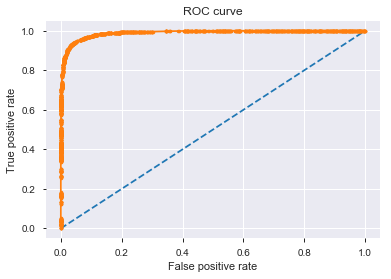

############# Test dataset  #########################################
Test confusion matrix
[[3496  436]
 [ 381 9805]]
[[0.88911495 0.11088505]
 [0.03740428 0.96259572]]
auc 0.984503906384983
gini 0.969007812769966
acc 0.9421306134013316
f1macro 0.9276905226694739
Nsample 14118
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      3932
           1       0.96      0.96      0.96     10186

   micro avg       0.94      0.94      0.94     14118
   macro avg       0.93      0.93      0.93     14118
weighted avg       0.94      0.94      0.94     14118



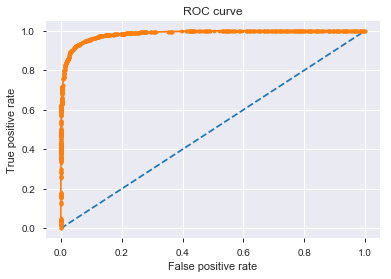

In [223]:
clf_lgb, clf_lgb_stats  = sk_model_eval_classification(clf_lgb, 1,
                                           Xtrain, ytrain, Xtest, ytest)


In [224]:
import shap
shap.initjs()

#dftest = pd.DataFrame( columns=colX, data=Xtest)

explainer = shap.TreeExplainer( clf_lgb )
shap_values = explainer.shap_values(  Xtest )


# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], Xtest.iloc[0,:] )





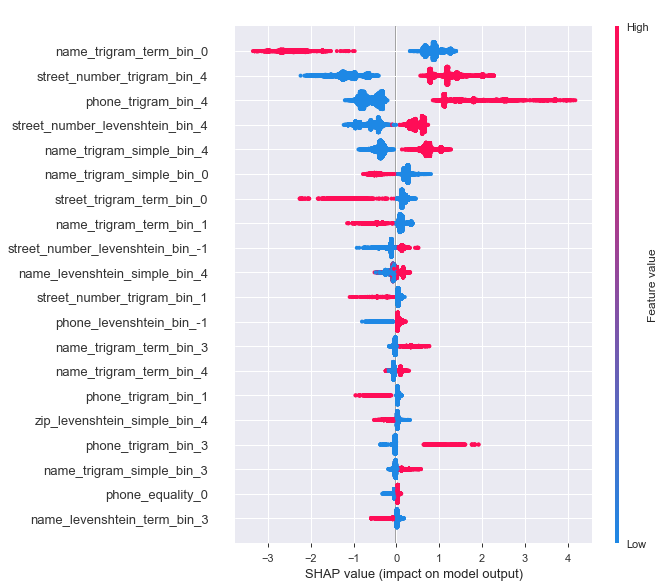

In [226]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, Xtest)



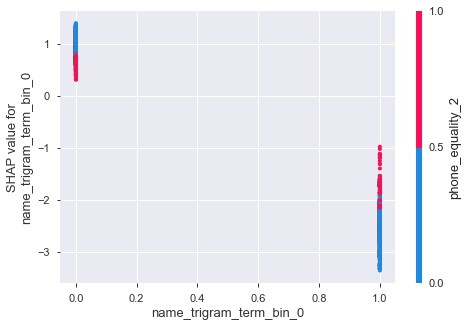

In [236]:
# visualize the training set predictions
shap.dependence_plot("name_trigram_term_bin_0", shap_values, Xtest.iloc[:,:]  )





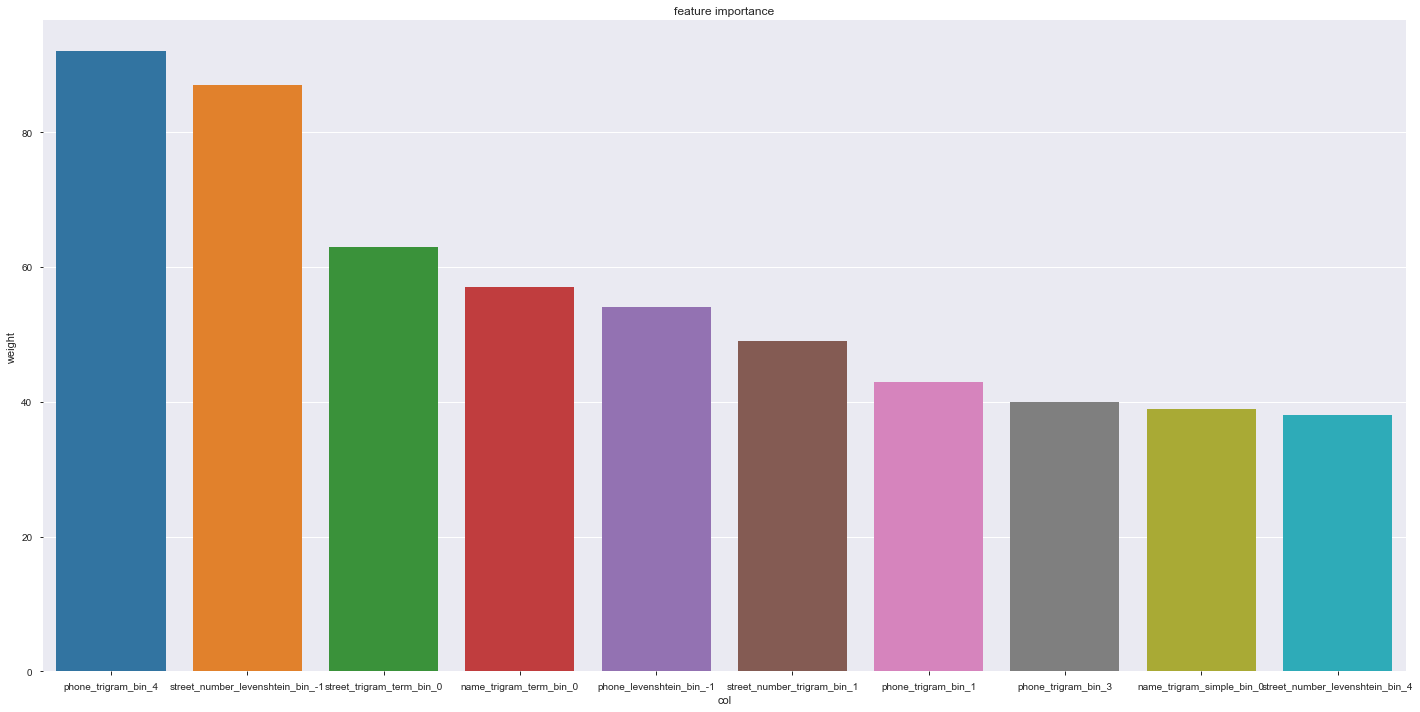

<Figure size 432x288 with 0 Axes>

In [261]:
lgb_feature_imp = util_feature.sk_feature_impt(clf_lgb.feature_importances_, colname= colX, model_type="lgb")


util_plot.plotbar(lgb_feature_imp.iloc[:10,:], colname=["col", "weight"],  
                  title="feature importance", savefile="lgb_feature_imp.png") 




In [262]:
kf = StratifiedKFold(n_splits=3, shuffle=True)
# partially based on https://www.kaggle.com/c0conuts/xgb-k-folds-fastai-pca
clf_list = []
for itrain, itest in kf.split(X, yy):
    print("###")
    Xtrain, Xval = X[ itrain ], X[ itest ]
    ytrain, yval = yy[ itrain ], yy[ itest ]
    clf_lgb.fit(Xtrain, ytrain, eval_set=[(Xval, yval)], 
            early_stopping_rounds=20)
    
    
    clf_list.append( clf_lgb)
    
    

    
lgb_feature_imp2 = util_model.sk_feature_impt(clf_lgb, colname= colall, model_type="lgb")




###
[1]	valid_0's l2: 0.165652
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l2: 0.138458
[3]	valid_0's l2: 0.117709
[4]	valid_0's l2: 0.101755
[5]	valid_0's l2: 0.0894591
[6]	valid_0's l2: 0.0800007
[7]	valid_0's l2: 0.0726722
[8]	valid_0's l2: 0.0668097
[9]	valid_0's l2: 0.0622689
[10]	valid_0's l2: 0.0587631
[11]	valid_0's l2: 0.0557934
[12]	valid_0's l2: 0.0534385
[13]	valid_0's l2: 0.0516411
[14]	valid_0's l2: 0.05025
[15]	valid_0's l2: 0.0490479
[16]	valid_0's l2: 0.0481288
[17]	valid_0's l2: 0.0473454
[18]	valid_0's l2: 0.0466832
[19]	valid_0's l2: 0.0460093
[20]	valid_0's l2: 0.0456373
[21]	valid_0's l2: 0.0452697
[22]	valid_0's l2: 0.0449898
[23]	valid_0's l2: 0.0447381
[24]	valid_0's l2: 0.0444604
[25]	valid_0's l2: 0.0441435
[26]	valid_0's l2: 0.043848
[27]	valid_0's l2: 0.0436615
[28]	valid_0's l2: 0.0434046
[29]	valid_0's l2: 0.0432684
[30]	valid_0's l2: 0.043172
[31]	valid_0's l2: 0.0429087
[32]	valid_0's l2: 0.0428253
[33]	valid_0's l2: 0.04

TypeError: sk_feature_impt() got an unexpected keyword argument 'model_type'

0
############# Test dataset  #########################################
Test confusion matrix
[[3521  411]
 [ 290 9896]]
[[0.89547304 0.10452696]
 [0.02847045 0.97152955]]
auc 0.9877143098689902
gini 0.9754286197379805
acc 0.950347074656467
f1macro 0.9376299063421794
Nsample 14118
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3932
           1       0.96      0.97      0.97     10186

   micro avg       0.95      0.95      0.95     14118
   macro avg       0.94      0.93      0.94     14118
weighted avg       0.95      0.95      0.95     14118



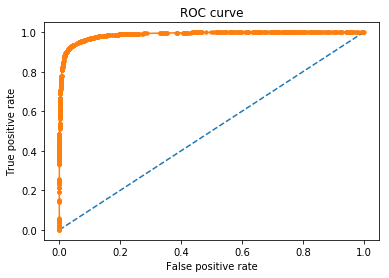

1
############# Test dataset  #########################################
Test confusion matrix
[[3521  411]
 [ 290 9896]]
[[0.89547304 0.10452696]
 [0.02847045 0.97152955]]
auc 0.9877143098689902
gini 0.9754286197379805
acc 0.950347074656467
f1macro 0.9376299063421794
Nsample 14118
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3932
           1       0.96      0.97      0.97     10186

   micro avg       0.95      0.95      0.95     14118
   macro avg       0.94      0.93      0.94     14118
weighted avg       0.95      0.95      0.95     14118



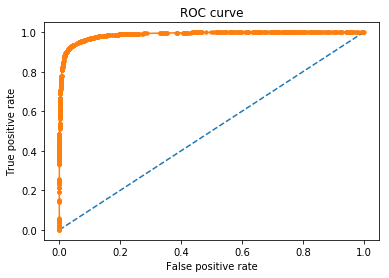

2
############# Test dataset  #########################################
Test confusion matrix
[[3521  411]
 [ 290 9896]]
[[0.89547304 0.10452696]
 [0.02847045 0.97152955]]
auc 0.9877143098689902
gini 0.9754286197379805
acc 0.950347074656467
f1macro 0.9376299063421794
Nsample 14118
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3932
           1       0.96      0.97      0.97     10186

   micro avg       0.95      0.95      0.95     14118
   macro avg       0.94      0.93      0.94     14118
weighted avg       0.95      0.95      0.95     14118



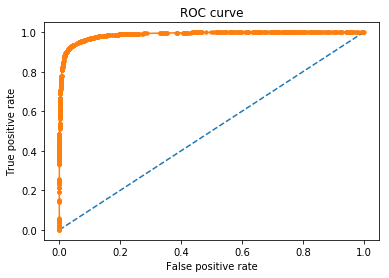

In [122]:
for i, clfi in enumerate( clf_list) :
    print(i)
    clf_lgbi, dd_lgbi = sk_model_eval_classification(clfi, 0,
                                               Xtrain, ytrain, Xtest, ytest)
    

## SVM

############# Train dataset  ####################################
Test confusion matrix
[[3480  561]
 [ 362 9714]]
[[0.86117298 0.13882702]
 [0.03592696 0.96407304]]
auc 0.9807684070748035
gini 0.961536814149607
acc 0.9346178366508465
f1macro 0.9187792800352295
Nsample 14117
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      4041
           1       0.95      0.96      0.95     10076

   micro avg       0.93      0.93      0.93     14117
   macro avg       0.93      0.91      0.92     14117
weighted avg       0.93      0.93      0.93     14117



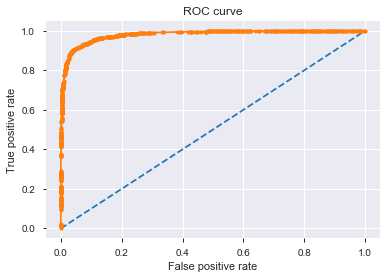

############# Test dataset  #########################################
Test confusion matrix
[[3380  552]
 [ 379 9807]]
[[0.85961343 0.14038657]
 [0.03720793 0.96279207]]
auc 0.9801308954564131
gini 0.9602617909128262
acc 0.9340558152712849
f1macro 0.9168171297808874
Nsample 14118
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      3932
           1       0.95      0.96      0.95     10186

   micro avg       0.93      0.93      0.93     14118
   macro avg       0.92      0.91      0.92     14118
weighted avg       0.93      0.93      0.93     14118



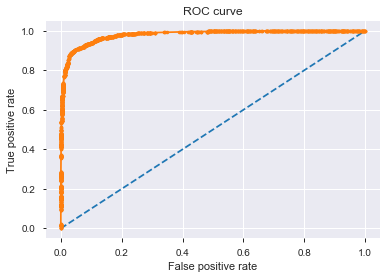

In [157]:

clf_svc = SVC(C=1.0, probability=True) # since we need probabilities

clf_svc, clf_svc_stats = sk_model_eval_classification(clf_svc, 1,
                                               Xtrain, ytrain, Xtest, ytest)



## Neural Network MLP Classifier

In [54]:

from sklearn.neural_network import MLPClassifier

clf_nn = MLPClassifier( hidden_layer_sizes=(50,), max_iter=80, alpha=1e-4,
                        activation="relu",
                        solver='adam', verbose=10, tol=1e-4, random_state=1,
                        learning_rate_init= 0.1, early_stopping=True, validation_fraction=0.2 )
                       
                     

############# Train dataset  ####################################
Iteration 1, loss = 0.30374545
Validation score: 0.919618
Iteration 2, loss = 0.15422258
Validation score: 0.922450
Iteration 3, loss = 0.15042476
Validation score: 0.924221
Iteration 4, loss = 0.14651006
Validation score: 0.927408
Iteration 5, loss = 0.14387765
Validation score: 0.928116
Iteration 6, loss = 0.13938971
Validation score: 0.925992
Iteration 7, loss = 0.13431603
Validation score: 0.924221
Iteration 8, loss = 0.13630725
Validation score: 0.932011
Iteration 9, loss = 0.13620662
Validation score: 0.926346
Iteration 10, loss = 0.13224484
Validation score: 0.921388
Iteration 11, loss = 0.13236208
Validation score: 0.921034
Iteration 12, loss = 0.12917632
Validation score: 0.929533
Iteration 13, loss = 0.12991413
Validation score: 0.926346
Iteration 14, loss = 0.12787154
Validation score: 0.928824
Iteration 15, loss = 0.12892515
Validation score: 0.920326
Iteration 16, loss = 0.12838998
Validation score: 0.926346

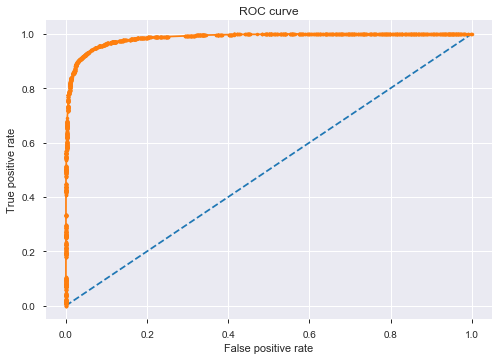

############# Test dataset  #########################################
Test confusion matrix
[[3490  442]
 [ 417 9769]]
[[0.88758901 0.11241099]
 [0.04093854 0.95906146]]
auc 0.9810311896587163
gini 0.9620623793174325
acc 0.9391556877744723
f1macro 0.9241528300059735
Nsample 14118
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3932
           1       0.96      0.96      0.96     10186

   micro avg       0.94      0.94      0.94     14118
   macro avg       0.92      0.92      0.92     14118
weighted avg       0.94      0.94      0.94     14118



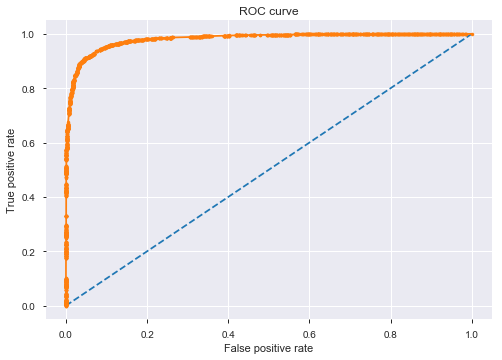

In [55]:
clf_nn, dd_nn = sk_model_eval_classification(clf_nn, 1,
                                           Xtrain, ytrain, Xtest, ytest)



# Feature selection


In [ ]:
### Feature Selection (reduce over-fitting)
   #Pre model feature selection (sometimes some features are useful even with low variance....)
   #Post model feature selection




In [59]:
### Model independant Selection
colX_kbest= util_model.sk_model_eval_feature(clf_nn,  method="f_classif", colname= colX, kbest=50,
                                 Xtrain= Xtrain, ytrain= ytrain)


print( colX_kbest )

['name_levenshtein_simple_bin_0', 'name_levenshtein_simple_bin_1', 'name_levenshtein_simple_bin_4', 'name_trigram_simple_bin_0', 'name_trigram_simple_bin_3', 'name_trigram_simple_bin_4', 'name_levenshtein_term_bin_0', 'name_levenshtein_term_bin_1', 'name_levenshtein_term_bin_4', 'name_trigram_term_bin_0', 'name_trigram_term_bin_3', 'name_trigram_term_bin_4', 'city_levenshtein_simple_bin_-1', 'city_levenshtein_simple_bin_4', 'city_trigram_simple_bin_-1', 'city_trigram_simple_bin_4', 'city_levenshtein_term_bin_-1', 'city_levenshtein_term_bin_4', 'city_trigram_term_bin_-1', 'city_trigram_term_bin_4', 'zip_levenshtein_simple_bin_-1', 'zip_levenshtein_simple_bin_4', 'zip_trigram_simple_bin_-1', 'zip_levenshtein_term_bin_-1', 'zip_levenshtein_term_bin_4', 'zip_trigram_term_bin_-1', 'zip_trigram_term_bin_1', 'street_levenshtein_simple_bin_0', 'street_levenshtein_simple_bin_1', 'street_trigram_simple_bin_0', 'street_trigram_simple_bin_1', 'street_levenshtein_term_bin_0', 'street_levenshtein_te

In [264]:
clf_log_feat[ :15 ] 


,feature,coef,coef_abs,rank
141,street_number_levenshtein_bin_0,-2.358337,2.358337,0
15,name_trigram_term_bin_0,-2.137965,2.137965,1
5,name_trigram_simple_bin_0,-2.093382,2.093382,2
87,street_trigram_term_bin_0,-2.021471,2.021471,3
126,phone_trigram_bin_3,1.977571,1.977571,4
9,name_trigram_simple_bin_4,1.926667,1.926667,5
18,name_trigram_term_bin_3,1.574609,1.574609,6
28,city_trigram_simple_bin_1,1.560024,1.560024,7
145,street_number_levenshtein_bin_4,1.502074,1.502074,8
127,phone_trigram_bin_4,1.466875,1.466875,9


In [80]:
clf_log.fit( dfX[colX].values , df[coly].values) 

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

(14117, 160) (14117,)
########## ['name_trigram_term_bin_0']
Test confusion matrix
[[2899 1033]
 [1001 9185]]
[[0.73728383 0.26271617]
 [0.09827214 0.90172786]]
auc 0.8195058433982453
gini 0.6390116867964906
acc 0.8559286017849553
f1macro 0.8203049423103763
Nsample 14118
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      3932
           1       0.90      0.90      0.90     10186

   micro avg       0.86      0.86      0.86     14118
   macro avg       0.82      0.82      0.82     14118
weighted avg       0.86      0.86      0.86     14118



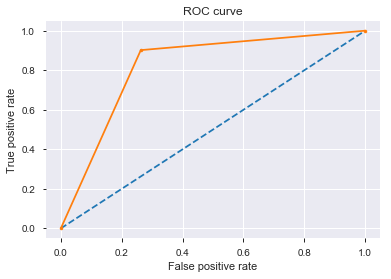

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3']
Test confusion matrix
[[2899 1033]
 [1001 9185]]
[[0.73728383 0.26271617]
 [0.09827214 0.90172786]]
auc 0.8213586647461988
gini 0.6427173294923976
acc 0.8559286017849553
f1macro 0.8203049423103763
Nsample 14118
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      3932
           1       0.90      0.90      0.90     10186

   micro avg       0.86      0.86      0.86     14118
   macro avg       0.82      0.82      0.82     14118
weighted avg       0.86      0.86      0.86     14118



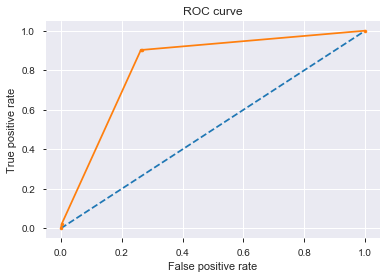

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0']
Test confusion matrix
[[3113  819]
 [1101 9085]]
[[0.79170905 0.20829095]
 [0.10808953 0.89191047]]
auc 0.8548047766277653
gini 0.7096095532555307
acc 0.8640033999150021
f1macro 0.8343657811881886
Nsample 14118
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      3932
           1       0.92      0.89      0.90     10186

   micro avg       0.86      0.86      0.86     14118
   macro avg       0.83      0.84      0.83     14118
weighted avg       0.87      0.86      0.87     14118



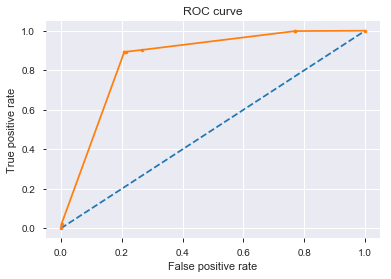

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0']
Test confusion matrix
[[3111  821]
 [1096 9090]]
[[0.79120041 0.20879959]
 [0.10759866 0.89240134]]
auc 0.857992409344883
gini 0.7159848186897659
acc 0.8642158946026349
f1macro 0.8345400040177421
Nsample 14118
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      3932
           1       0.92      0.89      0.90     10186

   micro avg       0.86      0.86      0.86     14118
   macro avg       0.83      0.84      0.83     14118
weighted avg       0.87      0.86      0.87     14118



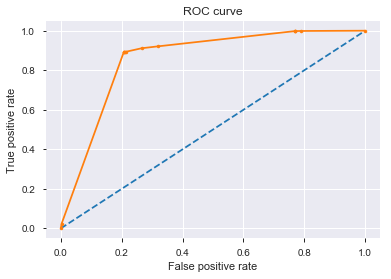

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4']
Test confusion matrix
[[3114  818]
 [1097 9089]]
[[0.79196338 0.20803662]
 [0.10769684 0.89230316]]
auc 0.9000051983263886
gini 0.8000103966527772
acc 0.8643575577277235
f1macro 0.8347609319721139
Nsample 14118
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      3932
           1       0.92      0.89      0.90     10186

   micro avg       0.86      0.86      0.86     14118
   macro avg       0.83      0.84      0.83     14118
weighted avg       0.87      0.86      0.87     14118



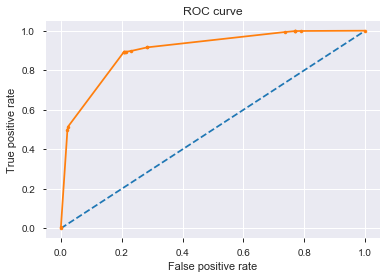

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1']
Test confusion matrix
[[3112  820]
 [1085 9101]]
[[0.79145473 0.20854527]
 [0.10651875 0.89348125]]
auc 0.9015095420499163
gini 0.8030190840998326
acc 0.8650658733531662
f1macro 0.835455353837288
Nsample 14118
              precision    recall  f1-score   support

           0       0.74      0.79      0.77      3932
           1       0.92      0.89      0.91     10186

   micro avg       0.87      0.87      0.87     14118
   macro avg       0.83      0.84      0.84     14118
weighted avg       0.87      0.87      0.87     14118



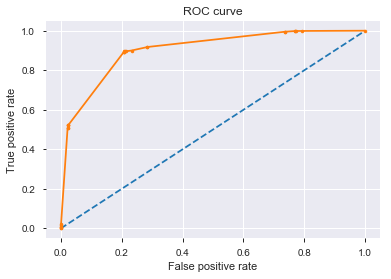

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1']
Test confusion matrix
[[3211  721]
 [1163 9023]]
[[0.81663276 0.18336724]
 [0.11417632 0.88582368]]
auc 0.9112047827998415
gini 0.822409565599683
acc 0.8665533361665958
f1macro 0.8393225796669272
Nsample 14118
              precision    recall  f1-score   support

           0       0.73      0.82      0.77      3932
           1       0.93      0.89      0.91     10186

   micro avg       0.87      0.87      0.87     14118
   macro avg       0.83      0.85      0.84     14118
weighted avg       0.87      0.87      0.87     14118



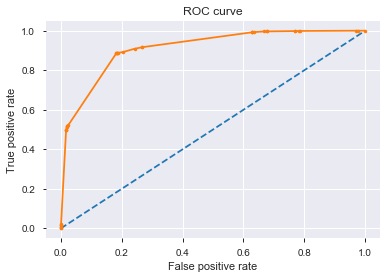

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3']
Test confusion matrix
[[3209  723]
 [1156 9030]]
[[0.81612411 0.18387589]
 [0.1134891  0.8865109 ]]
auc 0.9154348896886177
gini 0.8308697793772355
acc 0.8669074939793172
f1macro 0.8396475890008579
Nsample 14118
              precision    recall  f1-score   support

           0       0.74      0.82      0.77      3932
           1       0.93      0.89      0.91     10186

   micro avg       0.87      0.87      0.87     14118
   macro avg       0.83      0.85      0.84     14118
weighted avg       0.87      0.87      0.87     14118



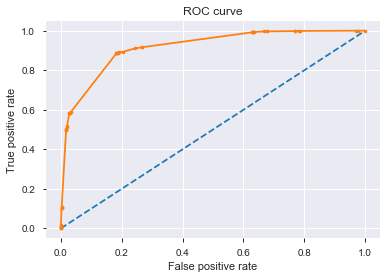

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2']
Test confusion matrix
[[3170  762]
 [ 565 9621]]
[[0.80620549 0.19379451]
 [0.05546829 0.94453171]]
auc 0.9458088206360674
gini 0.8916176412721348
acc 0.9060065165037541
f1macro 0.8812030039620862
Nsample 14118
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      3932
           1       0.93      0.94      0.94     10186

   micro avg       0.91      0.91      0.91     14118
   macro avg       0.89      0.88      0.88     14118
weighted avg       0.90      0.91      0.91     14118



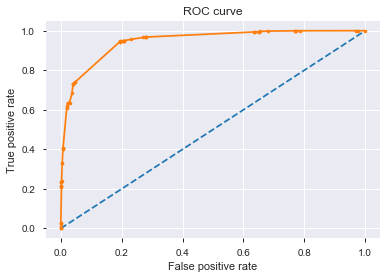

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4']
Test confusion matrix
[[3170  762]
 [ 565 9621]]
[[0.80620549 0.19379451]
 [0.05546829 0.94453171]]
auc 0.9458088206360674
gini 0.8916176412721348
acc 0.9060065165037541
f1macro 0.8812030039620862
Nsample 14118
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      3932
           1       0.93      0.94      0.94     10186

   micro avg       0.91      0.91      0.91     14118
   macro avg       0.89      0.88      0.88     14118
weighted avg       0.90      0.91      0.91     14118



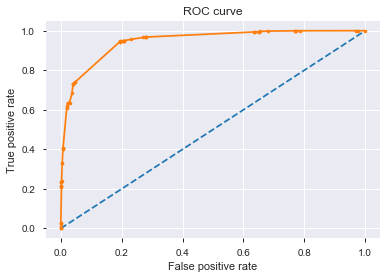

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4']
Test confusion matrix
[[3726  206]
 [1155 9031]]
[[0.94760936 0.05239064]
 [0.11339093 0.88660907]]
auc 0.9709518794771274
gini 0.9419037589542547
acc 0.9035982433772489
f1macro 0.887748740544021
Nsample 14118
              precision    recall  f1-score   support

           0       0.76      0.95      0.85      3932
           1       0.98      0.89      0.93     10186

   micro avg       0.90      0.90      0.90     14118
   macro avg       0.87      0.92      0.89     14118
weighted avg       0.92      0.90      0.91     14118



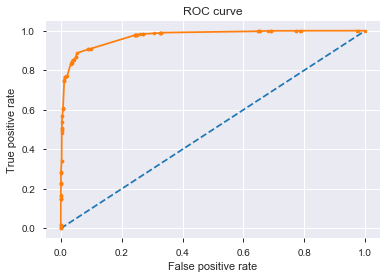

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1']
Test confusion matrix
[[3747  185]
 [1224 8962]]
[[0.95295015 0.04704985]
 [0.12016493 0.87983507]]
auc 0.9740914613818777
gini 0.9481829227637555
acc 0.9001983283751239
f1macro 0.88442908642216
Nsample 14118
              precision    recall  f1-score   support

           0       0.75      0.95      0.84      3932
           1       0.98      0.88      0.93     10186

   micro avg       0.90      0.90      0.90     14118
   macro avg       0.87      0.92      0.88     14118
weighted avg       0.92      0.90      0.90     14118



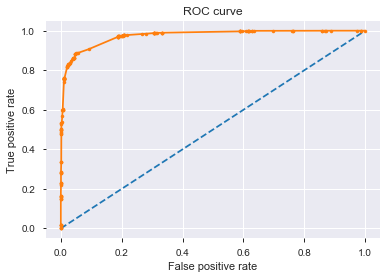

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1']
Test confusion matrix
[[3754  178]
 [1229 8957]]
[[0.95473042 0.04526958]
 [0.1206558  0.8793442 ]]
auc 0.9750310426474492
gini 0.9500620852948984
acc 0.9003399915002125
f1macro 0.8846768949991297
Nsample 14118
              precision    recall  f1-score   support

           0       0.75      0.95      0.84      3932
           1       0.98      0.88      0.93     10186

   micro avg       0.90      0.90      0.90     14118
   macro avg       0.87      0.92      0.88     14118
weighted avg       0.92      0.90      0.90     14118



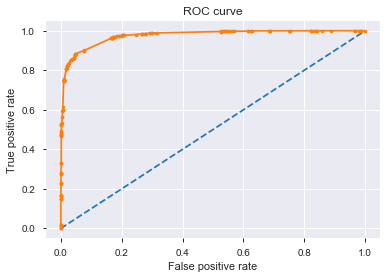

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2']
Test confusion matrix
[[3760  172]
 [1238 8948]]
[[0.95625636 0.04374364]
 [0.12153937 0.87846063]]
auc 0.9753266131939816
gini 0.9506532263879632
acc 0.9001274968125796
f1macro 0.8845354866499098
Nsample 14118
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      3932
           1       0.98      0.88      0.93     10186

   micro avg       0.90      0.90      0.90     14118
   macro avg       0.87      0.92      0.88     14118
weighted avg       0.92      0.90      0.90     14118



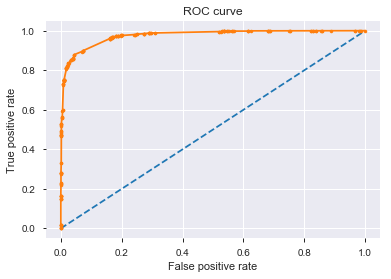

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4']
Test confusion matrix
[[3760  172]
 [1238 8948]]
[[0.95625636 0.04374364]
 [0.12153937 0.87846063]]
auc 0.9753446650190485
gini 0.950689330038097
acc 0.9001274968125796
f1macro 0.8845354866499098
Nsample 14118
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      3932
           1       0.98      0.88      0.93     10186

   micro avg       0.90      0.90      0.90     14118
   macro avg       0.87      0.92      0.88     14118
weighted avg       0.92      0.90      0.90     14118



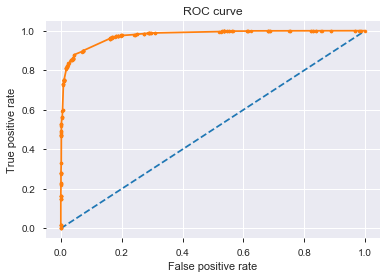

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4']
Test confusion matrix
[[3750  182]
 [1182 9004]]
[[0.95371312 0.04628688]
 [0.11604163 0.88395837]]
auc 0.9755284041347718
gini 0.9510568082695436
acc 0.9033857486896161
f1macro 0.8878541156203714
Nsample 14118
              precision    recall  f1-score   support

           0       0.76      0.95      0.85      3932
           1       0.98      0.88      0.93     10186

   micro avg       0.90      0.90      0.90     14118
   macro avg       0.87      0.92      0.89     14118
weighted avg       0.92      0.90      0.91     14118



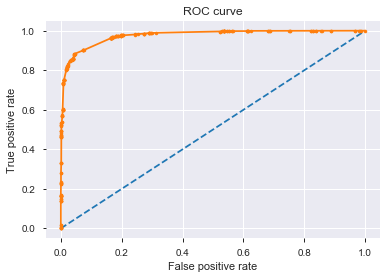

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3']
Test confusion matrix
[[3749  183]
 [1191 8995]]
[[0.9534588  0.0465412 ]
 [0.11692519 0.88307481]]
auc 0.9755316000318791
gini 0.9510632000637582
acc 0.9026774330641734
f1macro 0.8870871672289724
Nsample 14118
              precision    recall  f1-score   support

           0       0.76      0.95      0.85      3932
           1       0.98      0.88      0.93     10186

   micro avg       0.90      0.90      0.90     14118
   macro avg       0.87      0.92      0.89     14118
weighted avg       0.92      0.90      0.91     14118


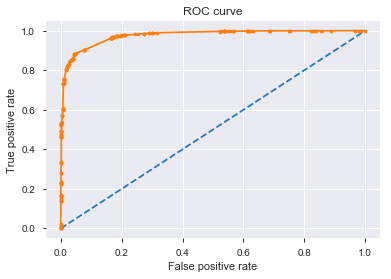

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3'
 'street_number_levenshtein_bin_0']
Test confusion matrix
[[3754  178]
 [1192 8994]]
[[0.95473042 0.04526958]
 [0.11702337 0.88297663]]
auc 0.9759212248315612
gini 0.9518424496631224
acc 0.9029607593143505
f1macro 0.8874570956819562
Nsample 14118
              precision    recall  f1-score   support

           0       0.76      0.95      0.85      3932
           1       0.98      0.88      0.93     10186

   micro avg       0.90      0.90      0.90     14118
   macro avg       0.87      0.92      0.89     14118
weighted avg       

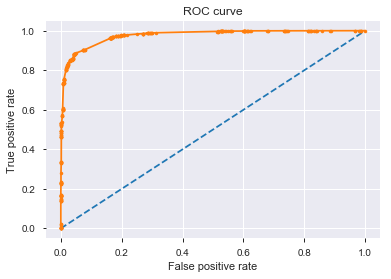

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3'
 'street_number_levenshtein_bin_0' 'website_trigram_term_bin_0']
Test confusion matrix
[[3748  184]
 [1187 8999]]
[[0.95320448 0.04679552]
 [0.1165325  0.8834675 ]]
auc 0.9759480653736733
gini 0.9518961307473466
acc 0.9028899277518062
f1macro 0.8872992711406089
Nsample 14118
              precision    recall  f1-score   support

           0       0.76      0.95      0.85      3932
           1       0.98      0.88      0.93     10186

   micro avg       0.90      0.90      0.90     14118
   macro avg       0.87      0.92      0.89 

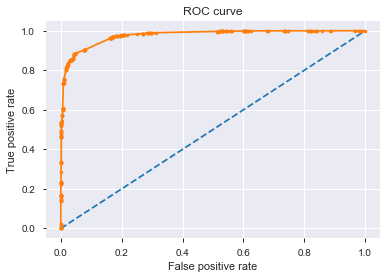

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3'
 'street_number_levenshtein_bin_0' 'website_trigram_term_bin_0'
 'phone_trigram_bin_-1']
Test confusion matrix
[[3748  184]
 [1187 8999]]
[[0.95320448 0.04679552]
 [0.1165325  0.8834675 ]]
auc 0.9759476658865349
gini 0.9518953317730698
acc 0.9028899277518062
f1macro 0.8872992711406089
Nsample 14118
              precision    recall  f1-score   support

           0       0.76      0.95      0.85      3932
           1       0.98      0.88      0.93     10186

   micro avg       0.90      0.90      0.90     14118
   macro avg       0

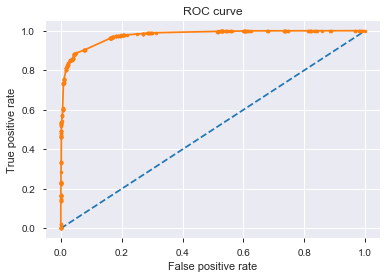

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3'
 'street_number_levenshtein_bin_0' 'website_trigram_term_bin_0'
 'phone_trigram_bin_-1' 'city_levenshtein_simple_bin_1']
Test confusion matrix
[[3750  182]
 [1190 8996]]
[[0.95371312 0.04628688]
 [0.11682702 0.88317298]]
auc 0.9761293701146468
gini 0.9522587402292937
acc 0.9028190961892619
f1macro 0.8872515236085518
Nsample 14118
              precision    recall  f1-score   support

           0       0.76      0.95      0.85      3932
           1       0.98      0.88      0.93     10186

   micro avg       0.90      0.90      0.9

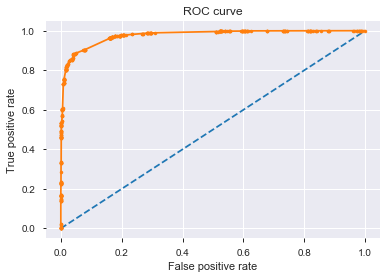

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3'
 'street_number_levenshtein_bin_0' 'website_trigram_term_bin_0'
 'phone_trigram_bin_-1' 'city_levenshtein_simple_bin_1'
 'zip_trigram_term_bin_1']
Test confusion matrix
[[3747  185]
 [1166 9020]]
[[0.95295015 0.04704985]
 [0.11447084 0.88552916]]
auc 0.9763255182996069
gini 0.9526510365992138
acc 0.9043065590026916
f1macro 0.8887934204789077
Nsample 14118
              precision    recall  f1-score   support

           0       0.76      0.95      0.85      3932
           1       0.98      0.89      0.93     10186

   micro avg    

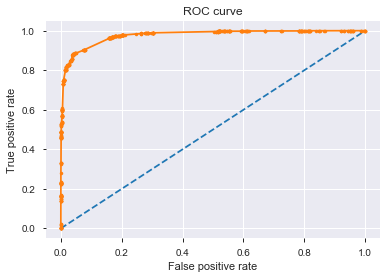

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3'
 'street_number_levenshtein_bin_0' 'website_trigram_term_bin_0'
 'phone_trigram_bin_-1' 'city_levenshtein_simple_bin_1'
 'zip_trigram_term_bin_1' 'website_trigram_term_bin_2']
Test confusion matrix
[[3746  186]
 [1165 9021]]
[[0.95269583 0.04730417]
 [0.11437267 0.88562733]]
auc 0.9763153188936045
gini 0.9526306377872089
acc 0.9043065590026916
f1macro 0.8887797404826907
Nsample 14118
              precision    recall  f1-score   support

           0       0.76      0.95      0.85      3932
           1       0.98      0.89      0.9

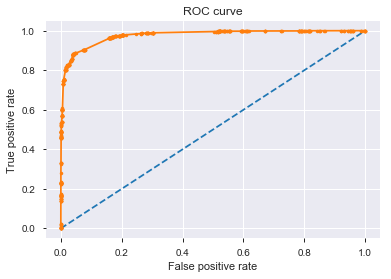

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3'
 'street_number_levenshtein_bin_0' 'website_trigram_term_bin_0'
 'phone_trigram_bin_-1' 'city_levenshtein_simple_bin_1'
 'zip_trigram_term_bin_1' 'website_trigram_term_bin_2'
 'zip_trigram_simple_bin_1']
Test confusion matrix
[[3746  186]
 [1166 9020]]
[[0.95269583 0.04730417]
 [0.11447084 0.88552916]]
auc 0.9762884783514924
gini 0.9525769567029847
acc 0.9042357274401474
f1macro 0.8887042622172665
Nsample 14118
              precision    recall  f1-score   support

           0       0.76      0.95      0.85      3932
           1  

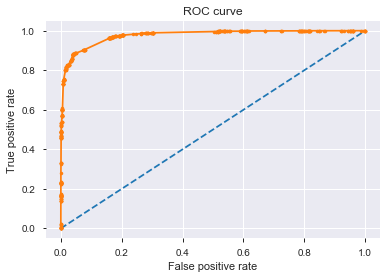

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3'
 'street_number_levenshtein_bin_0' 'website_trigram_term_bin_0'
 'phone_trigram_bin_-1' 'city_levenshtein_simple_bin_1'
 'zip_trigram_term_bin_1' 'website_trigram_term_bin_2'
 'zip_trigram_simple_bin_1' 'zip_trigram_simple_bin_3']
Test confusion matrix
[[3746  186]
 [1162 9024]]
[[0.95269583 0.04730417]
 [0.11407815 0.88592185]]
auc 0.9763647054910906
gini 0.9527294109821811
acc 0.9045190536903244
f1macro 0.88900622323584
Nsample 14118
              precision    recall  f1-score   support

           0       0.76      0.95      0.85

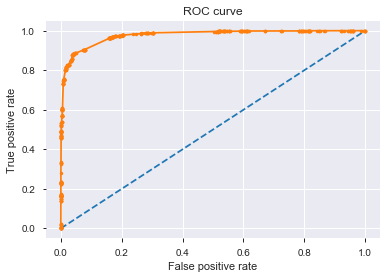

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3'
 'street_number_levenshtein_bin_0' 'website_trigram_term_bin_0'
 'phone_trigram_bin_-1' 'city_levenshtein_simple_bin_1'
 'zip_trigram_term_bin_1' 'website_trigram_term_bin_2'
 'zip_trigram_simple_bin_1' 'zip_trigram_simple_bin_3'
 'website_trigram_term_bin_3']
Test confusion matrix
[[3746  186]
 [1161 9025]]
[[0.95269583 0.04730417]
 [0.11397997 0.88602003]]
auc 0.9764048289805547
gini 0.9528096579611094
acc 0.9045898852528687
f1macro 0.8890817334862415
Nsample 14118
              precision    recall  f1-score   support

           

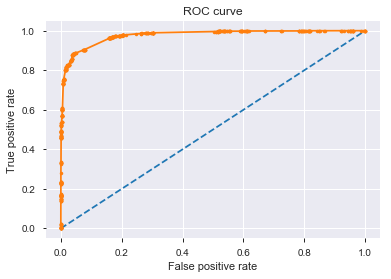

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3'
 'street_number_levenshtein_bin_0' 'website_trigram_term_bin_0'
 'phone_trigram_bin_-1' 'city_levenshtein_simple_bin_1'
 'zip_trigram_term_bin_1' 'website_trigram_term_bin_2'
 'zip_trigram_simple_bin_1' 'zip_trigram_simple_bin_3'
 'website_trigram_term_bin_3' 'name_trigram_simple_bin_3']
Test confusion matrix
[[3713  219]
 [ 949 9237]]
[[0.94430315 0.05569685]
 [0.09316709 0.90683291]]
auc 0.9777357453501194
gini 0.9554714907002388
acc 0.917268734948293
f1macro 0.9023134067222411
Nsample 14118
              precision    recall  f1-s

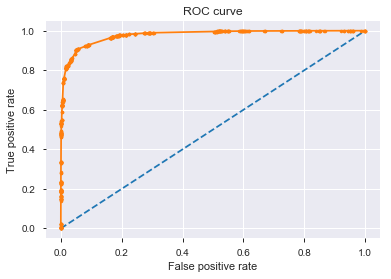

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3'
 'street_number_levenshtein_bin_0' 'website_trigram_term_bin_0'
 'phone_trigram_bin_-1' 'city_levenshtein_simple_bin_1'
 'zip_trigram_term_bin_1' 'website_trigram_term_bin_2'
 'zip_trigram_simple_bin_1' 'zip_trigram_simple_bin_3'
 'website_trigram_term_bin_3' 'name_trigram_simple_bin_3'
 'street_number_levenshtein_bin_1']
Test confusion matrix
[[3713  219]
 [ 953 9233]]
[[0.94430315 0.05569685]
 [0.09355979 0.90644021]]
auc 0.9777870794474054
gini 0.9555741588948108
acc 0.9169854086981158
f1macro 0.9020045091096509
Nsample 14118
   

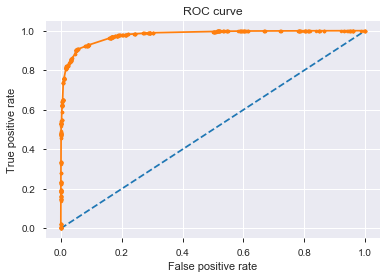

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3'
 'street_number_levenshtein_bin_0' 'website_trigram_term_bin_0'
 'phone_trigram_bin_-1' 'city_levenshtein_simple_bin_1'
 'zip_trigram_term_bin_1' 'website_trigram_term_bin_2'
 'zip_trigram_simple_bin_1' 'zip_trigram_simple_bin_3'
 'website_trigram_term_bin_3' 'name_trigram_simple_bin_3'
 'street_number_levenshtein_bin_1' 'website_levenshtein_simple_bin_3']
Test confusion matrix
[[3715  217]
 [ 954 9232]]
[[0.9448118  0.0551882 ]
 [0.09365796 0.90634204]]
auc 0.9777664434399118
gini 0.9555328868798236
acc 0.9170562402606601
f1macro 0

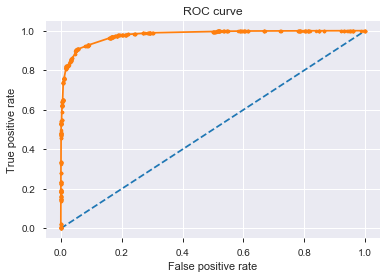

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3'
 'street_number_levenshtein_bin_0' 'website_trigram_term_bin_0'
 'phone_trigram_bin_-1' 'city_levenshtein_simple_bin_1'
 'zip_trigram_term_bin_1' 'website_trigram_term_bin_2'
 'zip_trigram_simple_bin_1' 'zip_trigram_simple_bin_3'
 'website_trigram_term_bin_3' 'name_trigram_simple_bin_3'
 'street_number_levenshtein_bin_1' 'website_levenshtein_simple_bin_3'
 'city_levenshtein_term_bin_4']
Test confusion matrix
[[3652  280]
 [ 825 9361]]
[[0.92878942 0.07121058]
 [0.08099352 0.91900648]]
auc 0.9784904015225254
gini 0.9569808030450508
a

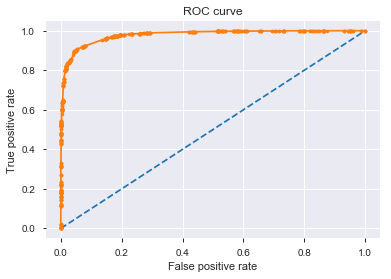

########## ['name_trigram_term_bin_0' 'phone_trigram_bin_3'
 'street_trigram_term_bin_0' 'name_trigram_simple_bin_0'
 'name_trigram_simple_bin_4' 'city_trigram_simple_bin_1'
 'phone_trigram_bin_1' 'name_trigram_term_bin_3' 'phone_equality_2'
 'phone_trigram_bin_4' 'street_number_levenshtein_bin_4'
 'street_number_trigram_bin_1' 'phone_equality_1'
 'street_number_equality_2' 'street_number_trigram_bin_4'
 'name_trigram_term_bin_4' 'street_trigram_term_bin_3'
 'street_number_levenshtein_bin_0' 'website_trigram_term_bin_0'
 'phone_trigram_bin_-1' 'city_levenshtein_simple_bin_1'
 'zip_trigram_term_bin_1' 'website_trigram_term_bin_2'
 'zip_trigram_simple_bin_1' 'zip_trigram_simple_bin_3'
 'website_trigram_term_bin_3' 'name_trigram_simple_bin_3'
 'street_number_levenshtein_bin_1' 'website_levenshtein_simple_bin_3'
 'city_levenshtein_term_bin_4' 'street_trigram_term_bin_2']


In [100]:

feat_eval= util_model.sk_feature_evaluation(clf_log, dfX, 30,  
                                 colname_best=clf_log_feat.feature.values, dfy= df[coly] )




In [95]:
feat_eval

,col,auc,acc,f1macro,confusion
0,['name_levenshtein_simple_bin_0'],0.631038,0.776172,0.645476,"([[1193, 2739], [421, 9765]], [[0.303407934893..."
1,"['name_levenshtein_simple_bin_0', 'name_levens...",0.792818,0.837300,0.794901,"([[2701, 1231], [1066, 9120]], [[0.68692777212..."
2,"['name_levenshtein_simple_bin_0', 'name_levens...",0.851844,0.776172,0.755688,"([[3435, 497], [2663, 7523]], [[0.873601220752..."
3,"['name_levenshtein_simple_bin_0', 'name_levens...",0.868101,0.776172,0.755688,"([[3435, 497], [2663, 7523]], [[0.873601220752..."
4,"['name_levenshtein_simple_bin_0', 'name_levens...",0.868101,0.776172,0.755688,"([[3435, 497], [2663, 7523]], [[0.873601220752..."
5,"['name_levenshtein_simple_bin_0', 'name_levens...",0.877016,0.776172,0.755688,"([[3435, 497], [2663, 7523]], [[0.873601220752..."
6,"['name_levenshtein_simple_bin_0', 'name_levens...",0.882447,0.841196,0.811242,"([[3126, 806], [1436, 8750]], [[0.795015259409..."
7,"['name_levenshtein_simple_bin_0', 'name_levens...",0.886406,0.841196,0.811242,"([[3126, 806], [1436, 8750]], [[0.795015259409..."
8,"['name_levenshtein_simple_bin_0', 'name_levens...",0.886846,0.841196,0.811242,"([[3126, 806], [1436, 8750]], [[0.795015259409..."
9,"['name_levenshtein_simple_bin_0', 'name_levens...",0.886931,0.841196,0.811242,"([[3126, 806], [1436, 8750]], [[0.795015259409..."


# Ensembling 

In [203]:
from sklearn.ensemble import VotingClassifier

clf_list = []
clf_list.append( ("clf_log", clf_log) )
clf_list.append( ("clf_lgb", clf_lgb) )
clf_list.append( ("clf_svc", clf_svc) )


clf_ens = VotingClassifier(clf_list, voting= "soft")  #Soft is required
print(clf_ens1)




VotingClassifier(estimators=[('clf_log', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)), ('cl...bf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)


############# Train dataset  ####################################
Test confusion matrix
[[3652  389]
 [ 440 9636]]
[[0.9037367  0.0962633 ]
 [0.04366812 0.95633188]]
auc 0.9862800204218786
gini 0.9725600408437571
acc 0.9412764751717787
f1macro 0.9284139318744533
Nsample 14117
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      4041
           1       0.96      0.96      0.96     10076

   micro avg       0.94      0.94      0.94     14117
   macro avg       0.93      0.93      0.93     14117
weighted avg       0.94      0.94      0.94     14117



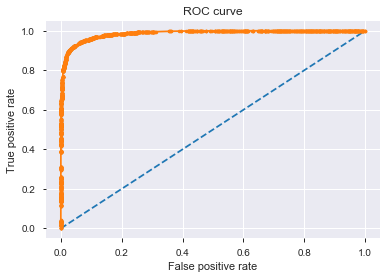

############# Test dataset  #########################################
Test confusion matrix
[[3520  412]
 [ 487 9699]]
[[0.89521872 0.10478128]
 [0.04781072 0.95218928]]
auc 0.9838409824467349
gini 0.9676819648934698
acc 0.9363224252727015
f1macro 0.9212346484656249
Nsample 14118
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3932
           1       0.96      0.95      0.96     10186

   micro avg       0.94      0.94      0.94     14118
   macro avg       0.92      0.92      0.92     14118
weighted avg       0.94      0.94      0.94     14118



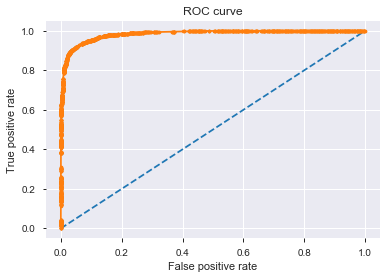

(VotingClassifier(estimators=[('clf_log', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
           solver='warn', tol=0.0001, verbose=0, warm_start=False)), ('cl...bf', max_iter=-1, probability=True, random_state=None,
   shrinking=True, tol=0.001, verbose=False))],
          flatten_transform=None, n_jobs=None, voting='soft', weights=None),
 {'ytest_pred': array([ 1, -1, -1, ...,  1,  1,  1], dtype=int64)})

In [204]:
sk_model_eval_classification(clf_ens, 1,
                                           Xtrain, ytrain, Xtest, ytest)


# Saving models

In [290]:
import util 
colname_list  =  [  "colnum", "colnum_bin",  
                  "colcat", "colcat_onehot" ] 
colname_list  = { x: globals()[x]   for x in colname_list }


folder_model = folder + "/models/model_01/" 





var_list = [
     "pipe_preprocess_colnum",  ## Pre-processors
     "pipe_preprocess_colcat",  ##
     
     ##### Data
     "df",
     "dfcat_hot",
     "dfnum_hot",
     "dfX",
     "colname_list",
      
     ##### Model
     "clf_log",
     "clf_lgb",
     "clf_svc"
        
     ]

util.save_all(var_list , folder_model, globals_main= globals() ) 
 
 

D:\_devs\Python01\gitdev\da\da//models/model_01/pipe_preprocess_colnum.pkl
D:\_devs\Python01\gitdev\da\da//models/model_01/pipe_preprocess_colcat.pkl
D:\_devs\Python01\gitdev\da\da//models/model_01/df.pkl
D:\_devs\Python01\gitdev\da\da//models/model_01/dfcat_hot.pkl
D:\_devs\Python01\gitdev\da\da//models/model_01/dfnum_hot.pkl
D:\_devs\Python01\gitdev\da\da//models/model_01/dfX.pkl
D:\_devs\Python01\gitdev\da\da//models/model_01/colname_list.pkl
D:\_devs\Python01\gitdev\da\da//models/model_01/clf_log.pkl
D:\_devs\Python01\gitdev\da\da//models/model_01/clf_lgb.pkl
D:\_devs\Python01\gitdev\da\da//models/model_01/clf_svc.pkl


In [280]:
util.save(clf_log , folder_model + "/clf_predict.pkl") 


'D:\\_devs\\Python01\\gitdev\\da\\da//models/model_01//clf_predict.pkl'

In [293]:
### Validate pkl data
for x in var_list :
  _ = util.load(  "{a}/{b}.pkl".format(a=folder_model, b=x  ))
  print(x)    
    
    
        

# Predict values

pipe_preprocess_colnum
pipe_preprocess_colcat
df
dfcat_hot
dfnum_hot
dfX
colname_list
clf_log
clf_lgb
clf_svc


In [182]:
dft = pd.read_csv(folder + '/data/address_matching_data.csv')

In [193]:
##### Pre-Process Giobally
coly = "is_match"
colid = "id"


dft = dft.set_index( colid)
dft = dft.replace("?",  np.nan)





In [194]:
dft.head(3)

,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,zip_trigram_simple,...,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality,is_match
id,,,,,,,,,,,,,,,,,,,,,
1204#1207,0.666667,0.666667,0.400000,0.526316,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,m,m,s,1
1272#1279,0.666667,0.666667,0.411765,0.444444,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,m,m,s,1
6258#6259,1.000000,1.000000,1.000000,1.000000,1,1,1,1,1,1,...,1.0,1.0,NaN,NaN,1.0,1.0,s,m,s,1


In [195]:
#### Pre-processing  cat :  ##################################
dft_cat = util_feature.pd_pipeline_apply( dft[colcat].iloc[:,:], 
                                            pipe_preprocess_colcat )  



dft_cat.head(4)

############## Pipeline  0 Start (28235, 3) pd_col_fillna
phone_equality 0 replaceBY -1
fax_equality 0 replaceBY -1
street_number_equality 0 replaceBY -1
############## Pipeline   0 Finished (28235, 3)
############## Pipeline  1 Start (28235, 3) pd_col_to_onehot
phone_equality 3 (28235, 3)
fax_equality 3 (28235, 5)
street_number_equality 3 (28235, 7)
phone_equality_0 added
phone_equality_1 added
phone_equality_2 added
fax_equality_0 added
fax_equality_1 added
fax_equality_2 added
street_number_equality_0 added
street_number_equality_1 added
street_number_equality_2 added
############## Pipeline   1 Finished (28235, 9)


,phone_equality_0,phone_equality_1,phone_equality_2,fax_equality_0,fax_equality_1,fax_equality_2,street_number_equality_0,street_number_equality_1,street_number_equality_2
id,,,,,,,,,
1204#1207,0,0,0,0,0,0,0,0,0
1272#1279,0,0,0,0,0,0,0,0,0
6258#6259,0,0,0,0,0,0,0,0,0
16076#16077,0,0,0,0,0,0,0,0,0


In [196]:
#### Pre-processing  cat : #################################################
dft_num = util_feature.pd_pipeline_apply( dft[colnum].iloc[:,:], 
                                            pipe_preprocess_colnum )  

dft_num.head(4)



############## Pipeline  0 Start (28235, 26) pd_col_to_num
############## Pipeline   0 Finished (28235, 26)
############## Pipeline  1 Start (28235, 26) pd_colnum_tocat
name_levenshtein_simple
                            name_levenshtein_simple                           
                                                min   size      mean       max
name_levenshtein_simple_bin                                                   
0                                               0.0   3244  0.133234  0.199916
1                                               0.2   4352  0.284679  0.399802
2                                               0.4   4713  0.495519  0.599206
3                                               0.6   4992  0.679888  0.797778
4                                               0.8  10934  0.945298  1.000000
name_trigram_simple
                        name_trigram_simple                           
                                        min   size      mean       max
name_trigram_

 4                             1.000000  
street_trigram_simple
                          street_trigram_simple                           
                                            min   size      mean       max
street_trigram_simple_bin                                                 
-1                                          NaN  19997       NaN       NaN
 0                                          0.0   1669  0.038069  0.198485
 1                                          0.2   1020  0.281841  0.399669
 2                                          0.4    575  0.499309  0.596875
 3                                          0.6   1026  0.706532  0.793651
 4                                          0.8   3948  0.958941  1.000000
street_levenshtein_term
                            street_levenshtein_term                           
                                                min   size      mean       max
street_levenshtein_term_bin                                                   


 4                             1.000000  
street_number_trigram
                          street_number_trigram                           
                                            min   size      mean       max
street_number_trigram_bin                                                 
-1                                          NaN   9852       NaN       NaN
 0                                          0.0    551  0.073064  0.181818
 1                                          0.2   3084  0.270634  0.375000
 2                                          0.4    684  0.447116  0.571429
 4                                          1.0  14064  1.000000  1.000000
############## Pipeline   1 Finished (28235, 26)
############## Pipeline  2 Start (28235, 26) pd_col_to_onehot
name_levenshtein_simple_bin 5 (28235, 26)
name_trigram_simple_bin 5 (28235, 30)
name_levenshtein_term_bin 5 (28235, 34)
name_trigram_term_bin 5 (28235, 38)
city_levenshtein_simple_bin 6 (28235, 42)
city_trigram_simple_bin 6 (

,name_levenshtein_simple_bin_0,name_levenshtein_simple_bin_1,name_levenshtein_simple_bin_2,name_levenshtein_simple_bin_3,name_levenshtein_simple_bin_4,name_trigram_simple_bin_0,name_trigram_simple_bin_1,name_trigram_simple_bin_2,name_trigram_simple_bin_3,name_trigram_simple_bin_4,...,street_number_levenshtein_bin_0,street_number_levenshtein_bin_1,street_number_levenshtein_bin_2,street_number_levenshtein_bin_3,street_number_levenshtein_bin_4,street_number_trigram_bin_-1,street_number_trigram_bin_0,street_number_trigram_bin_1,street_number_trigram_bin_2,street_number_trigram_bin_4
id,,,,,,,,,,,,,,,,,,,,,
1204#1207,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
1272#1279,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
6258#6259,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
16076#16077,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [197]:
df_final = pd.concat(( dft_cat, dft_num  ), axis=1)
col_final = list( df_final.columns )

df_final.head(5)


,phone_equality_0,phone_equality_1,phone_equality_2,fax_equality_0,fax_equality_1,fax_equality_2,street_number_equality_0,street_number_equality_1,street_number_equality_2,name_levenshtein_simple_bin_0,...,street_number_levenshtein_bin_0,street_number_levenshtein_bin_1,street_number_levenshtein_bin_2,street_number_levenshtein_bin_3,street_number_levenshtein_bin_4,street_number_trigram_bin_-1,street_number_trigram_bin_0,street_number_trigram_bin_1,street_number_trigram_bin_2,street_number_trigram_bin_4
id,,,,,,,,,,,,,,,,,,,,,
1204#1207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1272#1279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6258#6259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
16076#16077,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2666#2671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [198]:
#### Train 
coly = "is_match"
dft[coly] = clf_log.predict( df_final.iloc[:,:])

dft.sample(frac=0.2).head(20)



,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,zip_trigram_simple,...,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality,is_match
id,,,,,,,,,,,,,,,,,,,,,
1042#1037,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,m,m,n,1
9074#9076,0.500000,0.500000,0.235294,0.434783,1,1,1,1,1,1,...,0.25,0.0833333358169,NaN,NaN,1.0,1.0,n,m,s,1
2138#2139,1.000000,1.000000,1.000000,1.000000,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,1.0,1.0,m,m,s,1
1265#1274,0.490476,0.315629,0.363636,0.238095,1,1,1,1,1,1,...,0.909090909091,0.600000023842,NaN,NaN,1.0,1.0,n,m,s,-1
7308#7309,0.604167,0.456667,0.600000,0.317073,1,1,1,1,0.6,0.222222,...,1.0,1.0,NaN,NaN,NaN,NaN,s,m,n,-1
3930#3934,0.126984,0.000000,0.153846,0.000000,1,1,1,1,1,1,...,0.272727272727,0.0909090936184,NaN,NaN,0.5,0.25,n,m,n,-1
1527#1528,0.857143,0.857143,0.840000,0.880000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.8,0.5,m,m,n,1
1283#1284,0.666667,0.666667,0.437500,0.470588,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,s,s,s,1
883#884,0.494444,0.366667,0.590909,0.343750,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,m,m,s,1


In [201]:
dft = dft.reset_index()

dft[[ "id", "is_match"  ]].to_csv("adress_pred.csv" , index=False, mode="w")




69